In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.mixed_precision import set_global_policy

# ⚙️ Enable mixed precision & XLA optimization
set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

# 📁 Dataset Paths
REAL_PATH = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences"
FAKE_PATH = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences"

# ⚙️ Constants
IMG_SIZE = 128
FRAME_COUNT = 10
BATCH_SIZE = 32
CLASS_NAMES = ["Real", "Fake"]

# 🎞️ Extract frames from a video
def extract_frames(video_path, frame_count=10, output_size=(128, 128)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // frame_count, 1)
    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)
        frames.append(frame)
    cap.release()
    return np.array(frames)

# 📄 Load video filenames
real_videos = sorted(os.listdir(REAL_PATH))
fake_videos = sorted(os.listdir(FAKE_PATH))

# ⚖️ Balance fake videos to real video count
fake_videos = fake_videos[:len(real_videos)]

# 🔀 70-30 Train-Test Split (Real and Fake Separately)
real_train, real_test = train_test_split(real_videos, test_size=0.3, random_state=42)
fake_train, fake_test = train_test_split(fake_videos, test_size=0.3, random_state=42)

# ✅ Final Counts
print(f"Real videos → Train: {len(real_train)}, Test: {len(real_test)}")
print(f"Fake videos → Train: {len(fake_train)}, Test: {len(fake_test)}")


Real videos → Train: 254, Test: 110
Fake videos → Train: 254, Test: 110


In [5]:
# -------- Multiple Model Definitions -------- #

# 🔹 Model 1: Basic ResNet50 with dropout and L2
def build_model_v1():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(1, activation='sigmoid', dtype=tf.float32)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# 🔹 Model 2: ResNet50 with lower dropout, no L2
def build_model_v2():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid', dtype=tf.float32)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# 🔹 Model 3: ResNet50 with aggressive dropout + L2
def build_model_v3():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(0.02)),
        Dropout(0.5),
        Dense(1, activation='sigmoid', dtype=tf.float32)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# -------- Data Augmentation Layer -------- #
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(0.1)
])


In [6]:
# -------- Helper to load video frames -------- #
def load_videos(video_list, label, base_path):
    X, y, video_ids = [], [], []

    for vid in tqdm(video_list, desc=f"Loading {'Real' if label==0 else 'Fake'} videos"):
        frames = extract_frames(os.path.join(base_path, vid), frame_count=FRAME_COUNT)
        if len(frames) < FRAME_COUNT:
            continue
        for frame in frames:
            frame_resized = tf.image.resize(frame, (IMG_SIZE, IMG_SIZE)).numpy()
            X.append(frame_resized)
            y.append(label)
            video_ids.append(vid)
    
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32), np.array(video_ids)

# -------- Load Training Data -------- #
X_real, y_real, _ = load_videos(real_train, 0, REAL_PATH)
X_fake, y_fake, _ = load_videos(fake_train, 1, FAKE_PATH)

X_train = np.concatenate((X_real, X_fake), axis=0)
y_train = np.concatenate((y_real, y_fake), axis=0)

# Normalize
X_train /= 255.0

# -------- Apply Data Augmentation -------- #
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=len(X_train))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# -------- Callbacks -------- #
early_stopping = EarlyStopping(monitor="loss", patience=3, restore_best_weights=True)

# -------- Train Multiple Models -------- #
models = {
    "Model_V1": build_model_v1(),
    "Model_V2": build_model_v2(),
    "Model_V3": build_model_v3(),
}

histories = {}

for name, model in models.items():
    print(f"\n🔧 Training {name}...")
    history = model.fit(train_ds, epochs=20, callbacks=[early_stopping])
    histories[name] = (model, history)


Loading Fake videos: 100%|██████████| 254/254 [15:52<00:00,  3.75s/it]


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🔧 Training Model_V1...
Epoch 1/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 131s 336ms/step - accuracy: 0.5005 - loss: 5.3956
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.5841 - loss: 4.7201
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.6143 - loss: 4.2355
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.6431 - loss: 3.7939
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.6650 - loss: 3.4487
Epoch 6/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.6757 - loss: 3.1437
Epoch 7/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.6914 - loss: 2.8658
Epoch 8/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.7026 - loss: 2.5478
Epoch 9/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.7208 - loss: 2.2780
Epoch 10/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.6997 - loss: 2.1067
Epoch 11/20
159/159 ━━━━━━━━━━━━━

In [7]:
# -------- Load Training Data for Evaluation -------- #
X_real_train_eval, y_real_train_eval, vid_ids_real_train = load_videos(real_train, 0, REAL_PATH)
X_fake_train_eval, y_fake_train_eval, vid_ids_fake_train = load_videos(fake_train, 1, FAKE_PATH)

X_train_eval = np.concatenate((X_real_train_eval, X_fake_train_eval), axis=0)
y_train_eval = np.concatenate((y_real_train_eval, y_fake_train_eval), axis=0)
video_ids_train = np.concatenate((vid_ids_real_train, vid_ids_fake_train), axis=0)

X_train_eval /= 255.0

# -------- Accuracy & Loss Only -------- #
from collections import defaultdict

print("\n🔍 Evaluating on Training Data...")

for name, (model, _) in histories.items():
    print(f"\n📊 Model: {name}")

    # Frame-level prediction
    y_probs = model.predict(X_train_eval, batch_size=BATCH_SIZE, verbose=0)
    y_pred = (y_probs > 0.5).astype(int).flatten()

    # Frame-level accuracy and loss
    loss, acc = model.evaluate(X_train_eval, y_train_eval, verbose=0)
    print(f"✅ Frame-Level Accuracy: {acc:.4f}")
    print(f"🔻 Frame-Level Loss: {loss:.4f}")

    # Video-level accuracy
    video_preds = defaultdict(list)
    video_labels = {}

    for i in range(len(video_ids_train)):
        video_preds[video_ids_train[i]].append(y_probs[i])
        video_labels[video_ids_train[i]] = int(y_train_eval[i])

    y_video_pred, y_video_true = [], []

    for vid, probs in video_preds.items():
        avg_prob = np.mean(probs)
        pred_label = int(avg_prob > 0.5)
        y_video_pred.append(pred_label)
        y_video_true.append(video_labels[vid])

    video_acc = accuracy_score(y_video_true, y_video_pred)
    print(f"🎬 Video-Level Accuracy: {video_acc:.4f}")


Loading Fake videos: 100%|██████████| 254/254 [15:46<00:00,  3.72s/it]



🔍 Evaluating on Training Data...

📊 Model: Model_V1
✅ Frame-Level Accuracy: 0.9477
🔻 Frame-Level Loss: 0.4954
🎬 Video-Level Accuracy: 0.9467

📊 Model: Model_V2
✅ Frame-Level Accuracy: 0.9509
🔻 Frame-Level Loss: 0.1606
🎬 Video-Level Accuracy: 0.9507

📊 Model: Model_V3
✅ Frame-Level Accuracy: 0.4966
🔻 Frame-Level Loss: 8.4118
🎬 Video-Level Accuracy: 0.4970


Loading Fake videos: 100%|██████████| 110/110 [06:58<00:00,  3.81s/it]



📊 Evaluating Model_V1...
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step
✅ Frame-Level Accuracy: 0.8909
📋 Classification Report:
               precision    recall  f1-score   support

        Real       0.96      0.81      0.88      1100
        Fake       0.84      0.97      0.90      1100

    accuracy                           0.89      2200
   macro avg       0.90      0.89      0.89      2200
weighted avg       0.90      0.89      0.89      2200



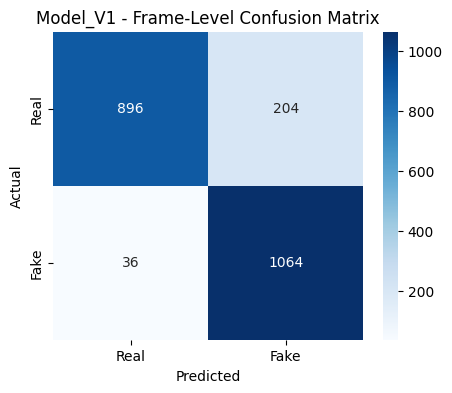

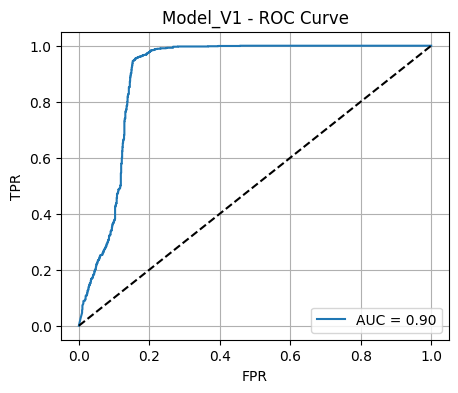


🎬 Video-Level Accuracy: 0.8955
📋 Video-Level Classification Report:
               precision    recall  f1-score   support

        Real       0.96      0.83      0.89       110
        Fake       0.85      0.96      0.90       110

    accuracy                           0.90       220
   macro avg       0.90      0.90      0.89       220
weighted avg       0.90      0.90      0.89       220


📊 Evaluating Model_V2...
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
✅ Frame-Level Accuracy: 0.9132
📋 Classification Report:
               precision    recall  f1-score   support

        Real       0.98      0.85      0.91      1100
        Fake       0.87      0.98      0.92      1100

    accuracy                           0.91      2200
   macro avg       0.92      0.91      0.91      2200
weighted avg       0.92      0.91      0.91      2200



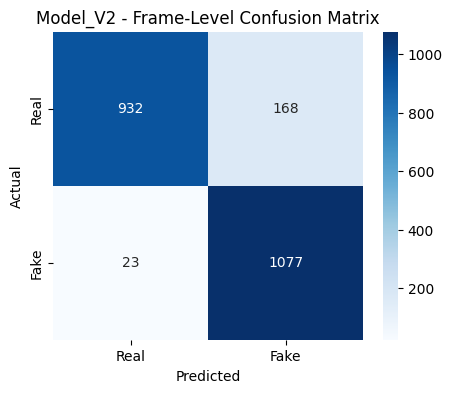

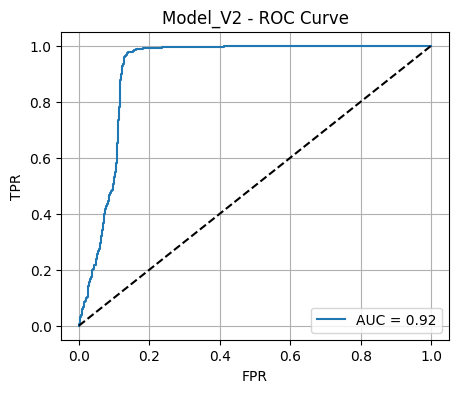


🎬 Video-Level Accuracy: 0.9227
📋 Video-Level Classification Report:
               precision    recall  f1-score   support

        Real       0.98      0.86      0.92       110
        Fake       0.88      0.98      0.93       110

    accuracy                           0.92       220
   macro avg       0.93      0.92      0.92       220
weighted avg       0.93      0.92      0.92       220


📊 Evaluating Model_V3...
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
✅ Frame-Level Accuracy: 0.5159
📋 Classification Report:
               precision    recall  f1-score   support

        Real       0.51      0.96      0.66      1100
        Fake       0.63      0.08      0.14      1100

    accuracy                           0.52      2200
   macro avg       0.57      0.52      0.40      2200
weighted avg       0.57      0.52      0.40      2200



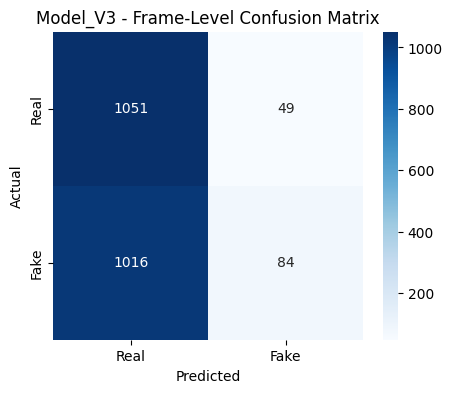

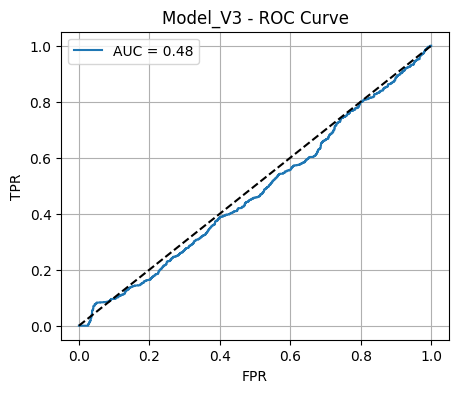


🎬 Video-Level Accuracy: 0.5182
📋 Video-Level Classification Report:
               precision    recall  f1-score   support

        Real       0.51      0.95      0.66       110
        Fake       0.64      0.08      0.15       110

    accuracy                           0.52       220
   macro avg       0.58      0.52      0.40       220
weighted avg       0.58      0.52      0.40       220


📌 Final Summary of Model Results:
      Model  Frame Accuracy  Video Accuracy   ROC AUC
1  Model_V2        0.913182        0.922727  0.916381
0  Model_V1        0.890909        0.895455  0.899294
2  Model_V3        0.515909        0.518182  0.477174


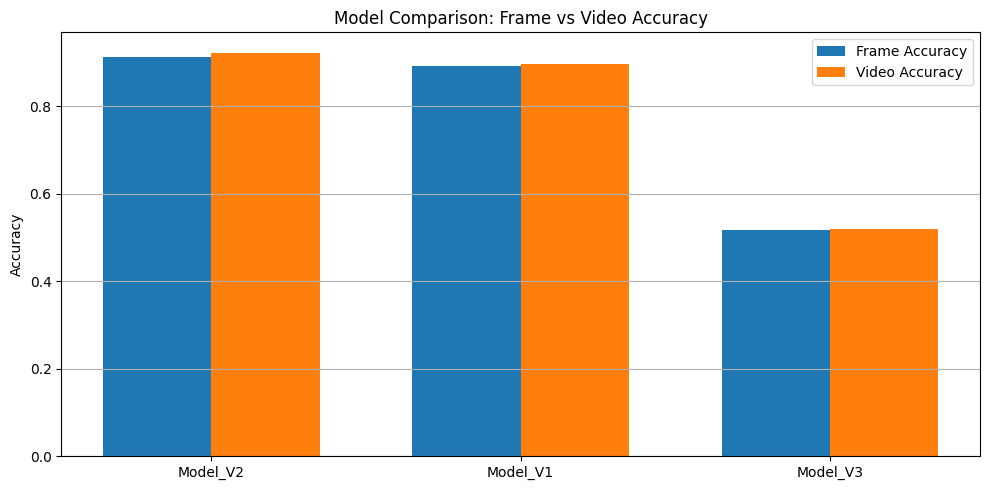

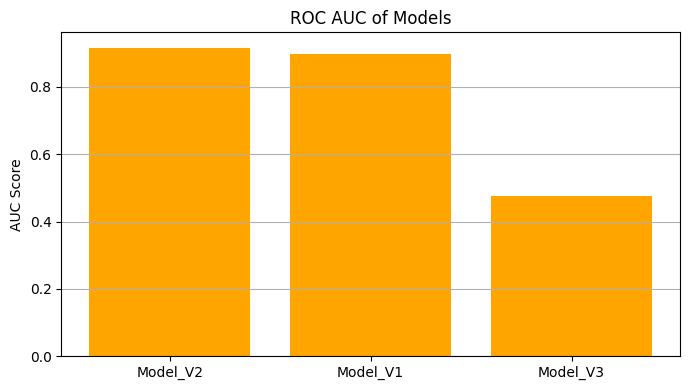

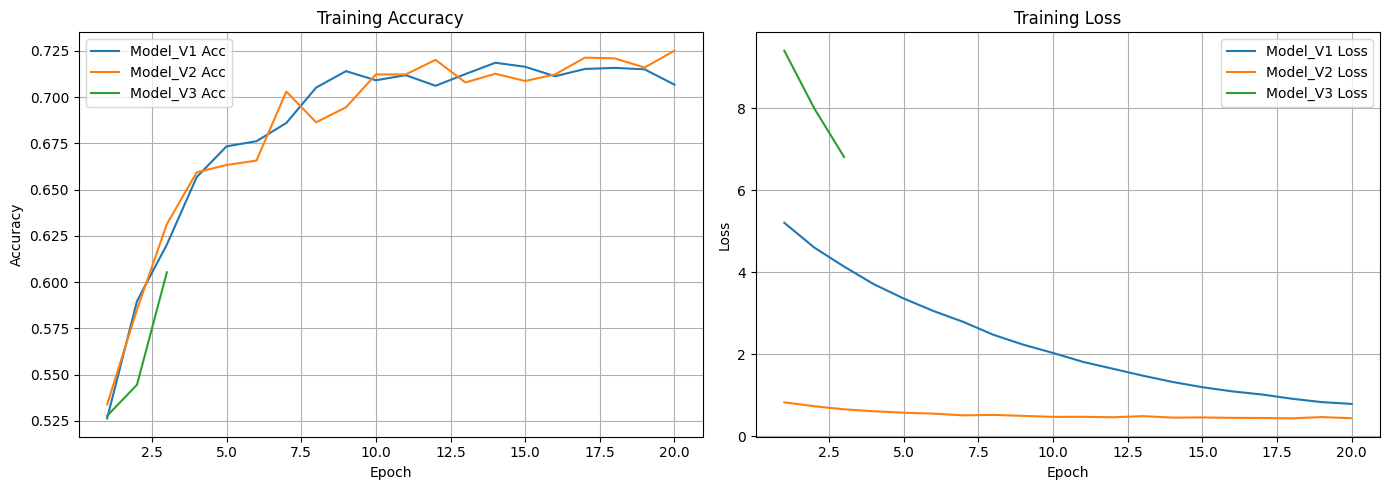

In [8]:
# -------- Load Test Data -------- #
X_real_test, y_real_test, vid_ids_real = load_videos(real_test, 0, REAL_PATH)
X_fake_test, y_fake_test, vid_ids_fake = load_videos(fake_test, 1, FAKE_PATH)

X_test = np.concatenate((X_real_test, X_fake_test), axis=0)
y_test = np.concatenate((y_real_test, y_fake_test), axis=0)
video_ids = np.concatenate((vid_ids_real, vid_ids_fake), axis=0)

# Normalize
X_test = X_test / 255.0

# -------- Evaluate All Models -------- #
from collections import defaultdict
import pandas as pd

results = []

for name, (model, history) in histories.items():
    print(f"\n📊 Evaluating {name}...")

    # Frame-level prediction
    y_probs = model.predict(X_test, batch_size=BATCH_SIZE)
    y_pred = (y_probs > 0.5).astype(int).flatten()

    # -------- Frame-level Metrics -------- #
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=CLASS_NAMES)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    print(f"✅ Frame-Level Accuracy: {acc:.4f}")
    print("📋 Classification Report:\n", report)

    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f"{name} - Frame-Level Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{name} - ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.grid(True)
    plt.show()

    # -------- Video-Level Evaluation -------- #
    video_preds = defaultdict(list)
    video_labels = {}

    for i in range(len(video_ids)):
        video_preds[video_ids[i]].append(y_probs[i])
        video_labels[video_ids[i]] = int(y_test[i])  # All frames of video have same label

    y_video_pred, y_video_true = [], []

    for vid, probs in video_preds.items():
        avg_prob = np.mean(probs)
        pred_label = int(avg_prob > 0.5)
        y_video_pred.append(pred_label)
        y_video_true.append(video_labels[vid])

    video_acc = accuracy_score(y_video_true, y_video_pred)
    video_cm = confusion_matrix(y_video_true, y_video_pred)
    video_report = classification_report(y_video_true, y_video_pred, target_names=CLASS_NAMES)

    print(f"\n🎬 Video-Level Accuracy: {video_acc:.4f}")
    print("📋 Video-Level Classification Report:\n", video_report)

    # Save results for comparison
    results.append({
        "Model": name,
        "Frame Accuracy": acc,
        "Video Accuracy": video_acc,
        "ROC AUC": roc_auc
    })

# -------- Summary & Visual Comparison -------- #
results_df = pd.DataFrame(results).sort_values(by="Video Accuracy", ascending=False)

print("\n📌 Final Summary of Model Results:")
print(results_df)

# 📊 Frame vs Video Accuracy
plt.figure(figsize=(10, 5))
bar_width = 0.35
x = np.arange(len(results_df["Model"]))

plt.bar(x - bar_width / 2, results_df["Frame Accuracy"], width=bar_width, label="Frame Accuracy")
plt.bar(x + bar_width / 2, results_df["Video Accuracy"], width=bar_width, label="Video Accuracy")
plt.xticks(x, results_df["Model"])
plt.ylabel("Accuracy")
plt.title("Model Comparison: Frame vs Video Accuracy")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 📊 ROC AUC Comparison
plt.figure(figsize=(7, 4))
plt.bar(results_df["Model"], results_df["ROC AUC"], color='orange')
plt.ylabel("AUC Score")
plt.title("ROC AUC of Models")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 📈 Training Curves
plt.figure(figsize=(14, 5))
for name, (_, history) in histories.items():
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label=f'{name} Acc')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label=f'{name} Loss')

plt.subplot(1, 2, 1)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:
# -------- Final Model Comparison -------- #
results_df = pd.DataFrame(results)
print("\n🔚 Final Results Summary:\n")
print(results_df.sort_values(by="Video Accuracy", ascending=False))



🔚 Final Results Summary:

      Model  Frame Accuracy  Video Accuracy   ROC AUC
1  Model_V2        0.913182        0.922727  0.916381
0  Model_V1        0.890909        0.895455  0.899294
2  Model_V3        0.515909        0.518182  0.477174
